# Classificação de Crédito

Iremos trabalhar com duas base de dados e realizaremos as seguintes operações:
- Tratamento de dados
- Construir variável de resposta
- Criar modelo de classificação


## O Problema
Uma empresa fictícia provedora de crédito deseja um modelo capaz de prever quais dos seus clientes serão bons ou maus pagadores, para isso eles forneceram duas base de dados. Uma com informações dos clientes e outra com informações dos pagamentos realizados dos créditos obtidos.

## Objetivo
Criar um modelo de classificação usando árvores de decisão

# 1. Preparando Base de Treino

In [1]:
# Importando bibliotecas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

pd.options.mode.copy_on_write = True

In [2]:
# Coletando dados
apr = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')
apr.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## 1.1 Preparando Dados

In [3]:
# Levantando informações sobre conjunto de dados
apr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

### Observações
A partir do leventamento de informações do conjunto de dados visto acima, é possível notar o seguinte:
- CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY e CNT_FAM_MEMBERS podem ser convertidos para **int**
- OCCUPATION_TYPE é a única coluna com dados faltantes

Para treinar o modelo usando o conjunto de dados, alguns ajustes são necessários, o primeiro desse é transformar as variáveis do tipo **object** para **int** através do método **map** e **astype** visto abaixo:

In [4]:
# Transformando variáveis 'object' em 'int'
apr['CODE_GENDER'] = apr['CODE_GENDER'].map({'F': 1, 'M': 0}) 
apr['FLAG_OWN_CAR'] = apr['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
apr['FLAG_OWN_REALTY'] = apr['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})

# Mudando do tipo 'float' para 'int'
apr['CNT_FAM_MEMBERS'] = apr['CNT_FAM_MEMBERS'].astype(np.int64)
apr.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1


O segundo ajuste necessário é remover linhas com alguma coluna com dados faltantes, uma vez que o **sklearn** não consegue processar dados nulos.

In [5]:
# Removendo dados nulos
before, _ = apr.shape
apr.dropna(inplace=True)
after, _ = apr.shape
print(f'Foram eliminadas {before-after} linhas com colunas vazias.')
print(apr.shape)
apr.head(5)

Foram eliminadas 134203 linhas com colunas vazias.
(304354, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
5,5008810,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
6,5008811,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1


Um último ajusto, vamos verificar a existência de linhas duplicadas no conjunto de dados utilizando da coluna 'ID'.

In [6]:
# Verificando se existe linhas duplicadas e sua quantidade
if apr['ID'].nunique() == apr.shape[0]:
    print('Não existem linhas duplicadas.')
else:
    vector = apr['ID'].value_counts() > 1
    print(f'Existe um total de {vector.value_counts().iloc[1]} linhas duplicadas.')

Existe um total de 23 linhas duplicadas.


In [7]:
# Removendo linhas duplicadas
before, _ = apr.shape
apr.drop_duplicates(subset='ID', inplace=True)
after, _ = apr.shape
print(f'Foi removido {before-after} linhas duplicadas.')

Foi removido 23 linhas duplicadas.


Por fim, vamos reajustar o indíce do conjunto de dados.

In [8]:
apr.reset_index(drop=True, inplace=True)
apr.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2
1,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
2,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
3,5008810,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
4,5008811,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1


Antes de rosseguirmos para a próxima etapa, vamos coletar os metadados do conjunto de dados atual e armazenar numa variável para comparação futura.

In [9]:
def metadata(df):
    return pd.DataFrame({'column': [col for col in df.columns], 'dtype': [df[col].dtype for col in df.columns]})

apr_before = metadata(apr)
apr_before

,column,dtype
0,ID,int64
1,CODE_GENDER,int64
2,FLAG_OWN_CAR,int64
3,FLAG_OWN_REALTY,int64
4,CNT_CHILDREN,int64
5,AMT_INCOME_TOTAL,float64
6,NAME_INCOME_TYPE,object
7,NAME_EDUCATION_TYPE,object
8,NAME_FAMILY_STATUS,object
9,NAME_HOUSING_TYPE,object


Através desse podemos notar que ainda existe transformações a serem feitas no conjunto de dados. 

## 1.2 Transformando Variáveis Qualitativas
Para que os dados sejam processados pelo modelo, é necessário transformar as variáveis **qualitativas** em **quantitativas discretas**, em outras palavras, transformar **variáveis categóricas** em **flags/dummies** para que o algoritmo de árvore de decisão consiga processar adequadamente esses dados.

Observando os metadados do conjunto, existem cinco colunas que devem passar por esse processo de transformação, são elas:
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- OCCUPATION_TYPE

In [10]:
# Criando dummies (v. quantitativas discretas)
v_qual = apr.loc[:, apr.dtypes == object]
dummies = pd.get_dummies(data=v_qual)
dummies = dummies.astype(np.int64)
dummies.head(5)

,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Agora que temos um conjunto de dados com todas as flags necessárias, podemos substituir elas no conjunto de dados inicial.

In [11]:
# Substituindo v. qualitativas por dummies
apr.drop(labels=v_qual, axis=1, inplace=True)
apr = pd.concat([apr, dummies], axis=1)
apr.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,5008806,0,1,1,0,112500.0,-21474,-1134,1,0,...,0,0,0,0,0,0,0,0,1,0
1,5008808,1,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0
2,5008809,1,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0
3,5008810,1,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0
4,5008811,1,0,1,0,270000.0,-19110,-3051,1,0,...,0,0,0,0,0,0,1,0,0,0


Para conferir as mudanças realizadas, vamos novamente retirar os metadados do conjunto de dados.

In [12]:
apr_after = metadata(apr)
apr_after

,column,dtype
0,ID,int64
1,CODE_GENDER,int64
2,FLAG_OWN_CAR,int64
3,FLAG_OWN_REALTY,int64
4,CNT_CHILDREN,int64
5,AMT_INCOME_TOTAL,float64
6,DAYS_BIRTH,int64
7,DAYS_EMPLOYED,int64
8,FLAG_MOBIL,int64
9,FLAG_WORK_PHONE,int64


Se comparado com os metados de antes, fica claro que o número de colunas aumentou e existem apenas tipos númericos (int e float) no conjunto de dados atual.

In [13]:
print(f"Colunas do conjunto de dados antes da categorização: {apr_before.shape[0]}")
print(f"Colunas do conjunto de dados após a categorização: {apr_after.shape[0]}\n")
print(f"Tipos de dados do conjunto de dados antes da categorização: {apr_before['dtype'].unique()}")
print(f"Tipos de dados do conjunto de dados após a categorização: {apr_after['dtype'].unique()}")

Colunas do conjunto de dados antes da categorização: 18
Colunas do conjunto de dados após a categorização: 52

Tipos de dados do conjunto de dados antes da categorização: [dtype('int64') dtype('float64') dtype('O')]
Tipos de dados do conjunto de dados após a categorização: [dtype('int64') dtype('float64')]


# 2. Construindo Variável De Resposta


Agora que conjunto de dados está adequado, vamos para a próxima etapa que é a construção da variável de resposta. Faremos isso através da manipulação do segundo conjunto de dados disponível, o registro de crédito dos clientes.

## 2.1 Preparando Dados

In [14]:
# Coletando dados
cr = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')
cr.head(5)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


Para melhor compreender o conjunto de dados, temos a variável **STATUS** que representa o quão atrasado foi efetuado o pagamento do crédito cedido, nesse caso temos:
- X - sem crédito cedido no mês
- C - pago dentro do prazo
- 0 - pago 1 dia após o prazo
- 1 - pago 30 dias após o prazo
- 2 - pago 60 dias após o prazo
- 3 - pago 90 dias após o prazo
- 4 - pago 120 dias após o prazo
- 5 - pago 150 dias após o prazo

Com base nisso, vamos classificar um cliente como **mau pagador** e vamos utilizar STATUS >= 1 como nossa threshold.

Mas antes, vamos agrupar os dados para que cada conjunto de variáveis corresponda a um único cliente.

In [15]:
grouped = cr.groupby('ID')[['MONTHS_BALANCE', 'STATUS']].agg(list)
grouped.head(5)

,MONTHS_BALANCE,STATUS
ID,,
5001711,"[0, -1, -2, -3]","[X, 0, 0, 0]"
5001712,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, 0, 0, 0, 0, 0, 0, ..."
5001713,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ..."
5001714,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X]"
5001715,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ..."


Para nosso treinamento, clientes que nunca receberam crédito são irrelevantes, por isso iremos removê-los do conjunto de dados.

In [16]:
# Removendo linhas com apenas registros 'X' em STATUS
vector = list(map(lambda row: row.count('X') == len(row), grouped.loc[:, 'STATUS']))
before, _ = grouped.shape
grouped.drop(grouped[vector].index, inplace=True)
after, _ = grouped.shape
print(f'Foi removido {before-after} linhas com clientes sem crédito cedido.')

Foi removido 4536 linhas com clientes sem crédito cedido.


Também vamos remover clientes que não estejam dentro da janela temporal mínima de 30 dias ou mais.

In [17]:
# Removendo linhas com menos de 30 registros em STATUS
vector = list(map(lambda row: len(row) < 30, grouped.loc[:, 'STATUS']))
before, _ = grouped.shape
grouped.drop(grouped[vector].index, inplace=True)
after, _ = grouped.shape
print(f'Foi removido {before-after} linhas com clientes com menos de 30 registros.')

Foi removido 28499 linhas com clientes com menos de 30 registros.


In [18]:
# Visualizando resultado final
grouped.head(5)

,MONTHS_BALANCE,STATUS
ID,,
5001718,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, 0, 0, 0, 0, 0, 1, X, 0, X, 1, X, 0, ..."
5001719,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ..."
5001720,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
5001723,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ..."
5001724,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ..."


Agora nosso conjunto de dados está pronto para ser usado para criar a variável de resposta.

## 2.2 Criando Variável

Para a criação da variável de resposta, primeiro foi considerada a frequêcia geral de atrasos de cada cliente ao longo de todo o período, clientes com uma frequência superior a média do conjunto irão atender a primeira condição para serem classificados como **maus pagadores**.

In [19]:
# Coletando a frequência de defaults ao longo de todo o período para cada cliente
def frequency(lst: list) -> float:
    acum = lst.count('0') + lst.count('1') + lst.count('2') + lst.count('3') + lst.count('4') + lst.count('5')
    freq = acum / len(lst)
    return freq

grouped['FREQUENCY'] = list(map(lambda row: frequency(row), grouped.loc[:, 'STATUS']))
grouped.head(5)

,MONTHS_BALANCE,STATUS,FREQUENCY
ID,,,
5001718,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, 0, 0, 0, 0, 0, 1, X, 0, X, 1, X, 0, ...",0.666667
5001719,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...",0.046512
5001720,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...",1.000000
5001723,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ...",0.258065
5001724,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...",0.000000


Para levar em conta a **gravidade** de cada atraso, uma segunda variável foi criada para representar a tendência de inadimplência do cliente, os clientes que estejam acima da média nesse valor atenderam a segunda condição para serem classificados como **maus pagadores**.

In [20]:
def risk_factor(lst: list) -> float:
    acum = lst.count('0') * 1 + lst.count('1') * 2 + lst.count('2') * 3 + lst.count('3') * 4 + lst.count('4') * 5 + lst.count('5') * 6
    risk = acum / len(lst)
    return risk

grouped['RISK_FACTOR'] = list(map(lambda row: risk_factor(row), grouped.loc[:, 'STATUS']))
grouped.head(5)

,MONTHS_BALANCE,STATUS,FREQUENCY,RISK_FACTOR
ID,,,,
5001718,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, 0, 0, 0, 0, 0, 1, X, 0, X, 1, X, 0, ...",0.666667,0.717949
5001719,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...",0.046512,0.046512
5001720,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...",1.000000,1.194444
5001723,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ...",0.258065,0.258065
5001724,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...",0.000000,0.000000


Agora vamos verificar quais clientes atendem as duas condições pré-estabelecidas:
- Frequência de inadimplência maior que a média do grupo
- Fator de risco maior que a média do grupo

In [21]:
index_default = grouped[(grouped['FREQUENCY'] > grouped['FREQUENCY'].mean()) & (grouped['RISK_FACTOR'] > grouped['RISK_FACTOR'].mean())].index
print(f'Existem {len(index_default)} clientes que atendem as condições.')

Existem 4332 clientes que atendem as condições.


Para armazenar quais clientes atendem essas condições e são **maus pagadores** vamos criar a variável DEFAULT e preencher ela de acordo com os ID que atendem as condições.

In [22]:
grouped['DEFAULT'] = 0
grouped.loc[index_default, 'DEFAULT'] = 1
grouped.head(5)

,MONTHS_BALANCE,STATUS,FREQUENCY,RISK_FACTOR,DEFAULT
ID,,,,,
5001718,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, 0, 0, 0, 0, 0, 1, X, 0, X, 1, X, 0, ...",0.666667,0.717949,1
5001719,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...",0.046512,0.046512,0
5001720,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...",1.000000,1.194444,1
5001723,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ...",0.258065,0.258065,0
5001724,"[0, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -...","[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, ...",0.000000,0.000000,0


## 2.3 Integrando Base de Dados

Agora que a variável de resposta foi criada, vamos integrar os dois conjuntos de dados em um só para começar o treinamento do modelo.

In [23]:
# Cria uma nova coluna DEFAULT com valores vazios
apr['DEFAULT'] = np.nan

# Cria um vetor booleano com os indíces que pertencem ao dataframe 'grouped' dentro de 'apr'
vector = apr['ID'].isin(grouped.index)

# Preenche a coluna DEFAULT com o valor 0 para todos os valores no vetor booleano
apr.loc[vector, 'DEFAULT'] = 0

# Visualiza
apr[['DEFAULT', 'ID']].head(5)

,DEFAULT,ID
0,0.0,5008806
1,NaN,5008808
2,NaN,5008809
3,NaN,5008810
4,0.0,5008811


In [24]:
# Cria um subconjunto com os valores de DEFAULT não nulos de 'apr' e pega apenas as colunas DEFAULT e ID
subset = apr[apr['DEFAULT'] == 0.0][['DEFAULT', 'ID']]

# Cria uma serie com os valores DEFAULT de 'grouped' dos indíces correspondentes
defaults = grouped.loc[subset['ID'], 'DEFAULT']

# Mapeia o subconjunto com os valores de defaults correspondentes aos ID de 'grouped'
subset['DEFAULT'] = subset['ID'].map(defaults)
subset.head(5)

,DEFAULT,ID
0,0,5008806
4,0,5008811
6,1,5112956
15,1,5008826
16,1,5008830


In [25]:
# Integra o subconjunto de volta ao dataframe original
apr.loc[subset.index, 'DEFAULT'] = subset['DEFAULT']
apr['DEFAULT'].value_counts()

DEFAULT
0.0    4275
1.0    2057
Name: count, dtype: int64

# 3. Treinando o Modelo

Com todas as etapas de preparação concluídas, vamos dar inicio ao treinamento do modelo de árvore de decisão.

## 3.1 Preparando Dados

Vamos eliminar quaisquer linhas vazias, nesse caso, linhas no conjunto de dados original que não possuí uma correspondência dentro do conjunto de dados de registro de crédito.

In [26]:
before, _ = apr.shape
apr.dropna(inplace=True)
after, _ = apr.shape
apr['DEFAULT'] = apr['DEFAULT'].astype(np.int64)
print(f'Foi removido {before-after} linhas vazias.')

Foi removido 297999 linhas vazias.


Como a coluna ID não é uma informação útil para o treinamento do modelo, vamos nos livrar dela.

In [27]:
apr.drop('ID', inplace=True, axis=1)
apr.head(5)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,DEFAULT
0,0,1,1,0,112500.0,-21474,-1134,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,270000.0,-19110,-3051,1,0,1,...,0,0,0,0,0,1,0,0,0,0
6,0,1,1,0,270000.0,-16872,-769,1,1,1,...,0,0,0,0,0,0,0,0,0,1
15,1,1,0,0,130500.0,-10669,-1103,1,0,0,...,0,0,0,0,0,0,0,0,0,1
16,1,0,1,0,157500.0,-10031,-1469,1,0,1,...,0,0,0,0,0,0,0,0,0,1


Antes de treinar o modelo, vamos observar a distribuição das observações de **maus pagadores** e **bons pagadores** dentro do conjunto de dados.

In [28]:
apr['DEFAULT'].value_counts() / apr['DEFAULT'].shape * 100

DEFAULT
0    67.514214
1    32.485786
Name: count, dtype: float64

É possível notar que existem mais **bons pagadores** no nosso conjunto de dados do que **maus pagadores**.

## 3.2 Treinamento com Todas as Variáveis

Primeiro, vamos tentar criar um modelo utilizando todas as variáveis do conjunto de dados.

[Text(0.6, 0.875, 'DAYS_BIRTH <= -12294.5\ngini = 0.439\nsamples = 4432\nvalue = [2987, 1445]\nclass = Aprovado'),
 Text(0.4, 0.625, 'AMT_INCOME_TOTAL <= 146250.0\ngini = 0.451\nsamples = 3415\nvalue = [2244, 1171]\nclass = Aprovado'),
 Text(0.2, 0.375, 'gini = 0.422\nsamples = 1195\nvalue = [833, 362]\nclass = Aprovado'),
 Text(0.6, 0.375, 'NAME_INCOME_TYPE_Working <= 0.5\ngini = 0.463\nsamples = 2220\nvalue = [1411, 809]\nclass = Aprovado'),
 Text(0.4, 0.125, 'gini = 0.478\nsamples = 879\nvalue = [532, 347]\nclass = Aprovado'),
 Text(0.8, 0.125, 'gini = 0.452\nsamples = 1341\nvalue = [879, 462]\nclass = Aprovado'),
 Text(0.8, 0.625, 'gini = 0.394\nsamples = 1017\nvalue = [743, 274]\nclass = Aprovado')]

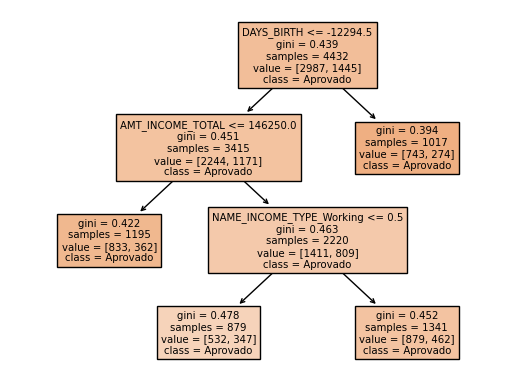

In [29]:
# Criando árvore de decisão
clf = DecisionTreeClassifier(random_state=100, 
                             criterion="gini", 
                             splitter="best", 
                             max_depth=5, 
                             min_samples_split=600,
                             min_samples_leaf=800)

# Dividindo conjunto de dados em X e Y
features = apr.loc[:, apr.columns != 'DEFAULT']
target = apr['DEFAULT']

# Subdividindo conjunto de dados em dados para treino e teste
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# Treinando o modelo
clf.fit(x_train, y_train)

# Visualizando a árvore
plot_tree(clf, filled=True, feature_names=apr.columns, class_names=['Aprovado', 'Reprovado'])

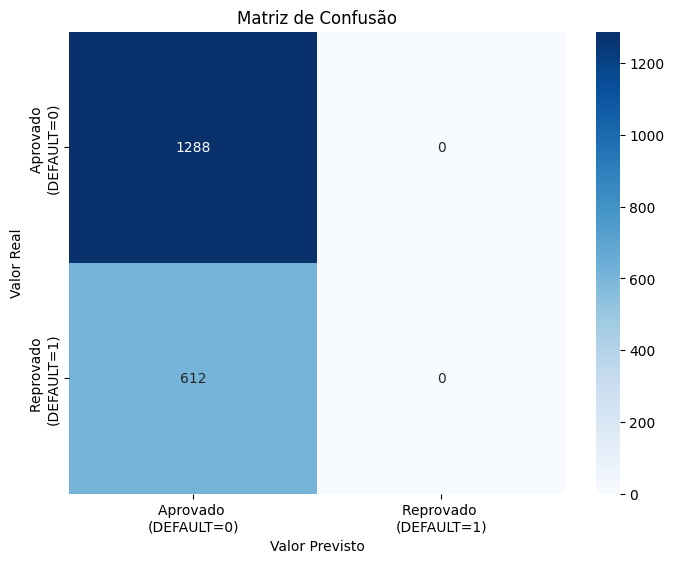

In [30]:
# Criando previsões
y_pred = clf.predict(x_test)

# Criando matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizando matriz de confusão
classes = ['Aprovado \n(DEFAULT=0)', 'Reprovado \n(DEFAULT=1)']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

In [31]:
ac_allv = accuracy_score(y_test, y_pred) * 100
print(f'A acurácia do modelo treinado com todas as variáveis é de {ac_allv:.2f}%')

A acurácia do modelo treinado com todas as variáveis é de 67.79%


## 3.3 Treinando o Modelo com Apenas Variáveis Contínuas

Agora vamos tentar criar um modelo que utiliza apenas valores contínuos.

In [32]:
apr_c = apr.loc[:, apr[:].nunique() > 2]
apr_c['DEFAULT'] = apr['DEFAULT']
apr_c.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,DEFAULT
0,0,112500.0,-21474,-1134,2,0
4,0,270000.0,-19110,-3051,1,0
6,0,270000.0,-16872,-769,2,1
15,0,130500.0,-10669,-1103,2,1
16,0,157500.0,-10031,-1469,2,1


[Text(0.6666666666666666, 0.875, 'DAYS_BIRTH <= -12294.5\ngini = 0.442\nsamples = 4432\nvalue = [2970, 1462]\nclass = Aprovado'),
 Text(0.5, 0.625, 'AMT_INCOME_TOTAL <= 191475.0\ngini = 0.454\nsamples = 3395\nvalue = [2215, 1180]\nclass = Aprovado'),
 Text(0.3333333333333333, 0.375, 'DAYS_EMPLOYED <= -2379.5\ngini = 0.436\nsamples = 1949\nvalue = [1324, 625]\nclass = Aprovado'),
 Text(0.16666666666666666, 0.125, 'gini = 0.413\nsamples = 1034\nvalue = [733, 301]\nclass = Aprovado'),
 Text(0.5, 0.125, 'gini = 0.457\nsamples = 915\nvalue = [591, 324]\nclass = Aprovado'),
 Text(0.6666666666666666, 0.375, 'gini = 0.473\nsamples = 1446\nvalue = [891, 555]\nclass = Aprovado'),
 Text(0.8333333333333334, 0.625, 'gini = 0.396\nsamples = 1037\nvalue = [755, 282]\nclass = Aprovado')]

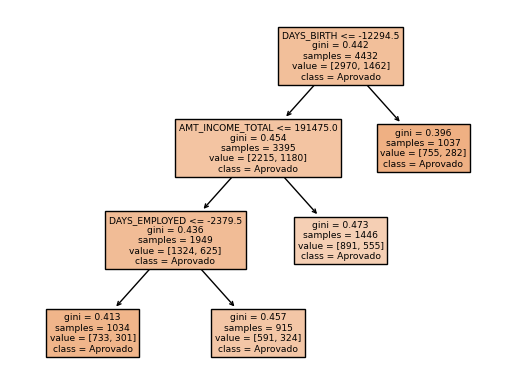

In [33]:
# Criando árvore
clf = DecisionTreeClassifier(random_state=100, 
                             criterion="gini", 
                             splitter="best", 
                             max_depth=5, 
                             min_samples_split=600,
                             min_samples_leaf=800)

# Dividindo conjunto de dados em X e Y
features = apr_c.loc[:, apr_c.columns != 'DEFAULT']
target = apr_c['DEFAULT']

# Subdividindo conjunto de dados em dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# Treinando modelo
clf.fit(x_train, y_train)

# Visualizando árvore
plot_tree(clf, filled=True, feature_names=apr_c.columns, class_names=['Aprovado', 'Reprovado'])

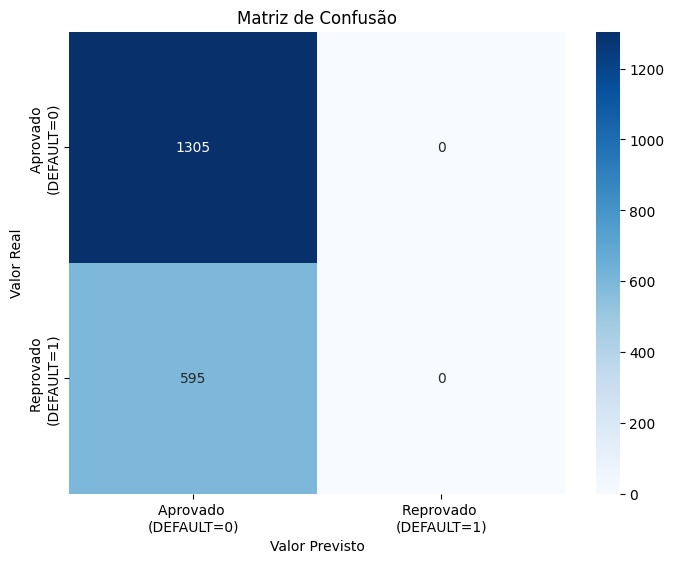

In [34]:
# Criando previsões
y_pred = clf.predict(x_test)

# Criando matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizando matriz de confusão
classes = ['Aprovado \n(DEFAULT=0)', 'Reprovado \n(DEFAULT=1)']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

In [35]:
ac_conv = accuracy_score(y_test, y_pred) * 100
print(f'A acurácia do modelo usando apenas valores contínuos é de {ac_conv:.2f}%')

A acurácia do modelo usando apenas valores contínuos é de 68.68%


## 3.4 Treinando Modelo com Apenas Variáveis Discretas

Por fim, vamos criar um terceiro modelo usando apenas valores discretos.

In [36]:
apr_d = apr.loc[:, apr[:].nunique() == 2]
apr_d

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,...,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,DEFAULT
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301680,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
301681,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
301685,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
301687,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


[Text(0.5441176470588235, 0.9375, 'NAME_FAMILY_STATUS_Civil marriage <= 0.5\ngini = 0.436\nsamples = 4432\nvalue = [3011, 1421]\nclass = Aprovado'),
 Text(0.4852941176470588, 0.8125, 'FLAG_OWN_REALTY <= 0.5\ngini = 0.439\nsamples = 4067\nvalue = [2744, 1323]\nclass = Aprovado'),
 Text(0.23529411764705882, 0.6875, 'FLAG_WORK_PHONE <= 0.5\ngini = 0.455\nsamples = 1433\nvalue = [931, 502]\nclass = Aprovado'),
 Text(0.11764705882352941, 0.5625, 'NAME_FAMILY_STATUS_Married <= 0.5\ngini = 0.469\nsamples = 837\nvalue = [523, 314]\nclass = Aprovado'),
 Text(0.058823529411764705, 0.4375, 'gini = 0.423\nsamples = 217\nvalue = [151, 66]\nclass = Aprovado'),
 Text(0.17647058823529413, 0.4375, 'NAME_INCOME_TYPE_Working <= 0.5\ngini = 0.48\nsamples = 620\nvalue = [372, 248]\nclass = Aprovado'),
 Text(0.11764705882352941, 0.3125, 'gini = 0.494\nsamples = 229\nvalue = [127, 102]\nclass = Aprovado'),
 Text(0.23529411764705882, 0.3125, 'gini = 0.468\nsamples = 391\nvalue = [245, 146]\nclass = Aprovado')

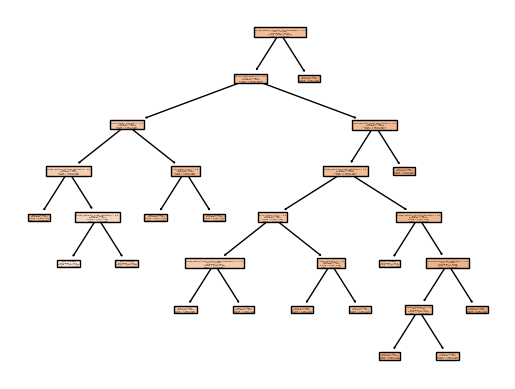

In [37]:
# Criando árvore de decisão
clf = DecisionTreeClassifier(random_state=100, 
                             criterion="gini", 
                             splitter="best", 
                             max_depth=10, 
                             min_samples_split=150,
                             min_samples_leaf=200)

# Dividindo conjunto de dados em X e Y
features = apr_d.loc[:, apr_d.columns != 'DEFAULT']
target = apr_d['DEFAULT']

# Subdividindo conjunto de dados em dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

# Treinando modelo
clf.fit(x_train, y_train)

# Visualizando árvore
plot_tree(clf, filled=True, feature_names=apr_d.columns, class_names=['Aprovado', 'Reprovado'])

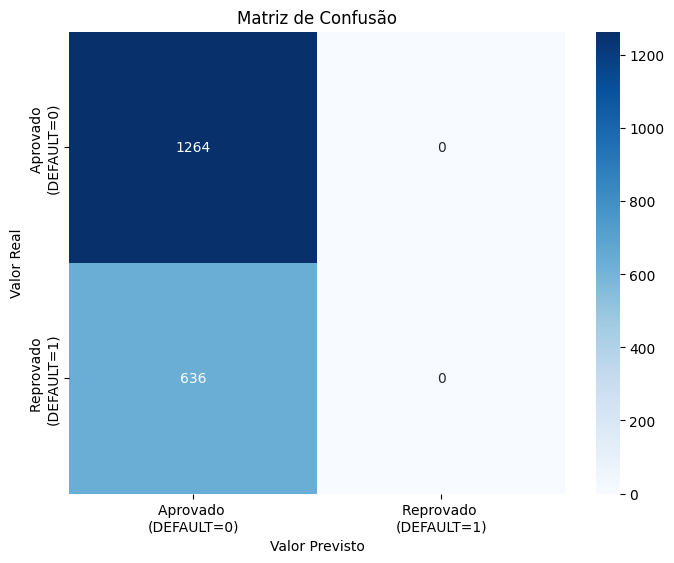

In [38]:
# Criando previsões
y_pred = clf.predict(x_test)

# Criando matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Visualizando matriz de confusão
classes = ['Aprovado \n(DEFAULT=0)', 'Reprovado \n(DEFAULT=1)']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

In [39]:
ac_disv = accuracy_score(y_test, y_pred) * 100
print(f'A acurácia do modelo criado usando apenas valores discretos é de {ac_disv:.2f}%')

A acurácia do modelo criado usando apenas valores discretos é de 66.53%


## 4. Conclusão

Através da manipulação do conjunto de dados foi criado uma variável de resposta e através da preparação dos dados três modelos diferentes foram treinados, abaixo segue a lista de acurácia de cada um:

In [40]:
print(f'Com todas as variáveis: {ac_allv:.2f}%')
print(f'Com variáveis contínuas: {ac_conv:.2f}%')
print(f'Com variáveis discretas: {ac_disv:.2f}%')

Com todas as variáveis: 67.79%
Com variáveis contínuas: 68.68%
Com variáveis discretas: 66.53%
